# Demo JulES as a solar with battery model

In [1]:
# using Pkg; Pkg.status()
# Pkg.instantiate()
# Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables") # package not in JulES environment (you might have to Pkg.build(PlotlyJS))
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"JulES")); Pkg.status() # go to development version
# Pkg.add(url="https://github.com/NVE/JulES.git"); Pkg.status() # alternative go back to latest version

### Import packages

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables, Revise
# plotlyjs(); # uncomment for interactive plots

In [3]:
config = YAML.load_file(joinpath("data", "config_jules_solbatteri.yml"))
# config = YAML.load_file(joinpath(dirname(dirname(dirname(dirname(pwd())))), "solbatteri_x", "config_jules_solbatteri_x_det.yml"))
weatheryear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1];

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 1


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

### Read dataset 

In [7]:
function getdataset(config, scenarioyear)
    elements = DataElement[]

    # Solar, battery and transmission parameters
    if haskey(config["data"], "transmcap")
        @assert !haskey(config["data"], "importcap") "importcap should not exist if transmcap exists"
        @assert !haskey(config["data"], "exportcap") "exportcap should not exist if transmcap exists"
        importcap = config["data"]["transmcap"] # MW
        exportcap = config["data"]["transmcap"] # MW
        
    else
        importcap = config["data"]["importcap"] # MW
        exportcap = config["data"]["exportcap"] # MW
    end
    transmeff = config["data"]["transmeff"] # Small loss to avoid unnecessary transfers
    storagecap = config["data"]["storagecap"] # GWh
    chargecap = config["data"]["chargecap"]# MW
    lossbattery = config["data"]["lossbattery"] # the whole loss when the battery charges
    solarcap = config["data"]["solarcap"] # MW
    pricedata = config["data"]["pricedata"]
    pricecolumn = config["data"]["pricecolumn"]
    solardata = config["data"]["solardata"]
    solarcolumn = config["data"]["solarcolumn"]

    # Power balances for price areas and transmission
    addexogenbalance!(elements, "PowerBalance_ExternalHub", "Power", "AreaPrice")
    price_path = joinpath(config["main"]["inputpath"], pricedata)
    if contains(price_path, "HydroCen")
        df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
        df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
        df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
        df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    else
        dfmt = dateformat"yyyy-mm-dd HH:MM:SS"
        df = CSV.read(price_path, DataFrame)
        df = subset(df, :modellaar => ByRow(==(datayear)))
        if length(unique(df.tsnitt)) == 56
            df.datetime .= getisoyearstart.(df.aar) + Week.(df.uke.-1) + Hour.((df.tsnitt.-1)*3)
        elseif length(unique(df.tsnitt)) == 168
            df.datetime .= getisoyearstart.(df.aar) + Week.(df.uke.-1) + Hour.((df.tsnitt.-1))
        else
            error("Resolution with $(length(unique(df.tsnitt))) different tsnitt not supported")
        end
    end
    pricevector = df[:,pricecolumn]
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => pricevector)))
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")

    push!(elements, getelement(BALANCE_CONCEPT, "BaseBalance", "PowerBalance_BatteryHub", (COMMODITY_CONCEPT, "Power"))) # without slack

    if importcap > 0
        addpowertrans!(elements, "PowerBalance_ExternalHub", "PowerBalance_BatteryHub", importcap, transmeff)
    end
    if exportcap > 0
        addpowertrans!(elements, "PowerBalance_BatteryHub", "PowerBalance_ExternalHub", exportcap, transmeff)
    end

    addbalance!(elements, "PowerBalance_SolarHub", "Power")
    flowname = "PowerBalance_SolarHub->PowerBalance_BatteryHub" # only one direction
    addcapacity!(elements, "Solar->BatteryCap", BOUNDUPPER, "SolParam", flowname, FLOW_CONCEPT)
    addflow!(elements, flowname)
    addarrow!(elements, flowname * "From", 1.0, flowname, "PowerBalance_SolarHub", DIRECTIONOUT)
    addarrow!(elements, flowname * "To", 1.0, flowname, "PowerBalance_BatteryHub", DIRECTIONIN)

    # Add battery
    addbattery!(elements, "Battery", "PowerBalance_BatteryHub", storagecap, lossbattery, chargecap)

    # Add solar production as an RHSTerm
    solar_path = joinpath(config["main"]["inputpath"], solardata) # profiles from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
    df = CSV.read(solar_path, DataFrame)
    dfmt = DateFormat("yyyy-mm-dd HH:MM:SS")
    datetimevector = DateTime.(df.Timestamp, dfmt)
    @assert issorted(datetimevector)
    solarvector = df[:, solarcolumn]
    if contains(solar_path, "testprofiles")
        start = first(datetimevector)
        numperiods = length(datetimevector)
        rotatingtype = "RotatingTimeVector"
    else
        if eltype(solarvector) != Float64
            solarvector = replace.(solarvector, "," => ".")
            solarvector = parse.(Float64, solarvector)/solarcap
        else
            solarvector = solarvector/solarcap
        end
        numperiods = length(solarvector)
        if numperiods > 8904
            startyear = year(first(datetimevector))
            start = getisoyearstart.(Int(startyear))
            rotatingtype = "RotatingTimeVector"
        else
            start = getisoyearstart(1992) # year with 53 weeks
            @assert numperiods == 8736 || numperiods == 8904
            if numperiods == 8736
                solarvector = vcat(solarvector, solarvector[end-167:end])
                numperiods = length(solarvector)
            end
            rotatingtype = "OneYearTimeVector"
        end
    end
    push!(elements, DataElement(TIMEINDEX_CONCEPT, "RangeTimeIndex", "SolProfileIndex", 
        Dict("Start" => start, "Delta" => Hour(1), "Steps" => numperiods)))
    push!(elements, DataElement(TIMEVECTOR_CONCEPT, rotatingtype, "SolProfil",
            Dict(TIMEVALUES_CONCEPT => "SolProfilValues", TIMEINDEX_CONCEPT => "SolProfileIndex")))
    push!(elements, DataElement(PARAM_CONCEPT, "MWToGWhSeriesParam", "SolParam", Dict("Level" => solarcap, "Profile" => "SolProfil")))
    push!(elements, DataElement(TIMEVALUES_CONCEPT, "VectorTimeValues", "SolProfilValues",
        Dict("Vector" => solarvector)))
    addrhsterm!(elements, "SolParam", "PowerBalance_SolarHub", DIRECTIONIN)

    return Dict("elements" => elements, "detailedrescopl" => Dict())
end


getdataset (generic function with 1 method)

### Run JulES and keep the results

In [8]:
dataset = getdataset(config, weatheryear)
input = JulES.DefaultJulESInput(config, dataset, datayear, weatheryear)
JulES.cleanup_jules(input)
data = JulES.run_serial(input)

Time parameters
  0.345798 seconds (210.22 k allocations: 13.299 MiB, 99.91% compilation time)
Handle elements
  0.000033 seconds (15 allocations: 6.719 KiB)
Add local dbs
  0.671870 seconds (501.68 k allocations: 32.750 MiB, 4.83% gc time, 99.93% compilation time)
Add local cores
  0.087119 seconds (21.76 k allocations: 1.255 MiB, 87.78% compilation time)
Add local input
  0.076163 seconds (12.37 k allocations: 769.924 KiB, 99.61% compilation time)
Add local dummyobjects
  1.951140 seconds (1.60 M allocations: 94.143 MiB, 1.75% gc time, 99.76% compilation time: 2% of which was recompilation)
Add local subsystems
  1.328292 seconds (1.11 M allocations: 71.348 MiB, 2.67% gc time, 99.95% compilation time)
Add local scenmod
  0.289223 seconds (172.75 k allocations: 10.794 MiB, 99.85% compilation time)
Add local problem distribution
Tuple{String, Int64}[]
[(1, 1)]
[(1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (6, 1, 1), (7, 1, 1), (8, 1, 1), (9, 1, 1), (10, 1, 1), (11, 1, 1), (12

1×15 DataFrame
 Row │ core     tot        evp_tot  mp_tot     sp_tot     evp_u    evp_s    ev ⋯
     │ Float64  Float64    Float64  Float64    Float64    Float64  Float64  Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.0  0.0568433      0.0  0.0149964  0.0418469      0.0      0.0     ⋯
                                                               8 columns omitted

1×16 DataFrame
 Row │ subix    tot        evp_tot  mp_tot     sp_tot     evp_u    evp_s    ev ⋯
     │ Float64  Float64    Float64  Float64    Float64    Float64  Float64  Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.0  0.0568433      0.0  0.0149964  0.0418469      0.0      0.0     ⋯
                                                               9 columns omitted

Dict{Any, Any} with 27 entries:
  "demandbalancenames" => SubString{String}["SolarHub", "SolarHub", "ExternalHu…
  "skipfactor"         => 1.0
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "areanames"          => ["BatteryHub", "SolarHub", "ExternalHub"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "batmatrix"          => [0.005; 0.005; … ; -0.0; 0.0;;]
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [0.01 0.0; 0.01 0.0; … ; 0.01 -0.0; 0.01 0.0]
  "statenames"         => ["BatteryStorage_Battery_max", "BatteryStorage_Batter…
  "resnames"           => String[]
  "shorts"             => Bool[1]
  "demandvalues"       => [-0.0 0.0 … 0.0 0.0; -0.0 0.0 … 0.0 -0.0; … ; -0.0 0.…
  "batindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "scenarionames"      => ["1 min", "1 max", "2 min", "2 max", "3 min", "3 max"…
  "storagenames"       

### Show some of the outputs

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

scenweights_sim = data["scenweights_sim"]
scenweights_stoch = data["scenweights_stoch"]

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"]
shorts = data["shorts"]
skipfactor = data["skipfactor"];

In [10]:
if haskey(config["main"], "outputpath") && haskey(config["main"], "outputname")
    datetime = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    outputfolder = joinpath(config["main"]["outputpath"], config["main"]["outputname"] * "_" * datetime)
    mkdir(outputfolder)

    areaprices = rename!(DataFrame(prices, :auto),powerbalancenames)
    areaprices[!,:time] = x1
    CSV.write(joinpath(outputfolder, "prices.csv"), areaprices)

    demand = rename!(DataFrame(demandvalues, :auto),demandnames)
    demand[!,:time] = x1
    demand = stack(demand,Not(:time))
    demandcopl = DataFrame(variable=demandnames, area=demandbalancenames)
    demand = leftjoin(demand, demandcopl, on=:variable)
    CSV.write(joinpath(outputfolder, "demand.csv"), demand)

    supply = rename!(DataFrame(supplyvalues, :auto),supplynames)
    supply[!,:time] = x1
    supply = stack(supply,Not(:time))
    supplycopl = DataFrame(variable=supplynames, area=supplybalancenames)
    supply = leftjoin(supply, supplycopl, on=:variable)
    CSV.write(joinpath(outputfolder, "supply.csv"), supply)

    battery = rename!(DataFrame(batterylevels, :auto),batterynames)
    battery[!,:time] = x2
    CSV.write(joinpath(outputfolder, "batteries.csv"), battery);
end

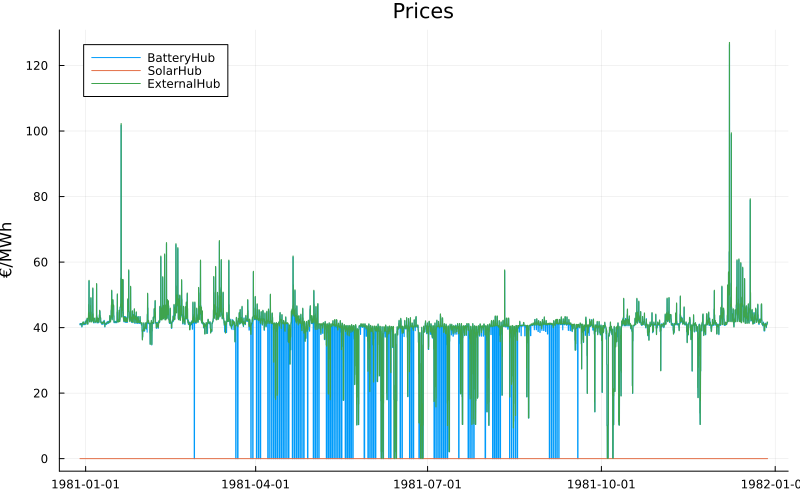

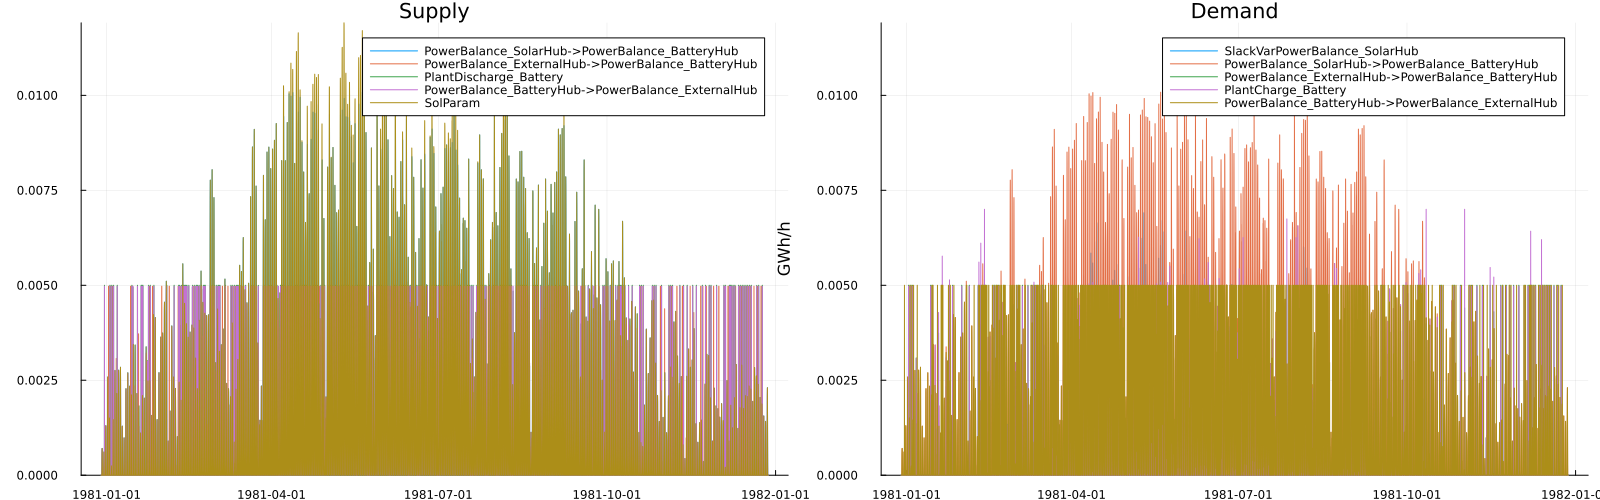

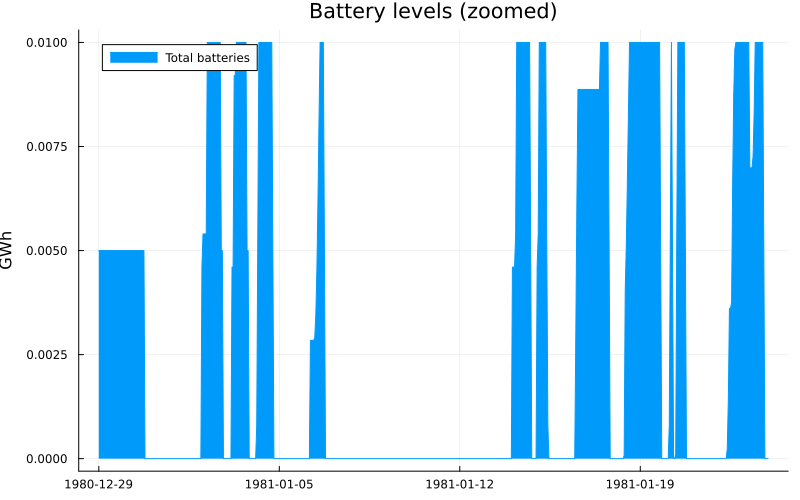

┌───────────────────────────────────────────────────┬───────────────────┬───────────────────────────────────────────────────┬───────────────────┐
│                                        Supplyname │ Yearly_supply_TWh │                                        Demandname │ Yearly_demand_TWh │
├───────────────────────────────────────────────────┼───────────────────┼───────────────────────────────────────────────────┼───────────────────┤
│                                          SolParam │          0.013782 │ PowerBalance_BatteryHub->PowerBalance_ExternalHub │         0.0133714 │
│ PowerBalance_BatteryHub->PowerBalance_ExternalHub │         0.0133045 │    PowerBalance_SolarHub->PowerBalance_BatteryHub │         0.0127583 │
│    PowerBalance_SolarHub->PowerBalance_BatteryHub │         0.0127583 │                               PlantCharge_Battery │        0.00284655 │
│                            PlantDischarge_Battery │        0.00263807 │                     SlackVarPowerBalance_SolarHub 

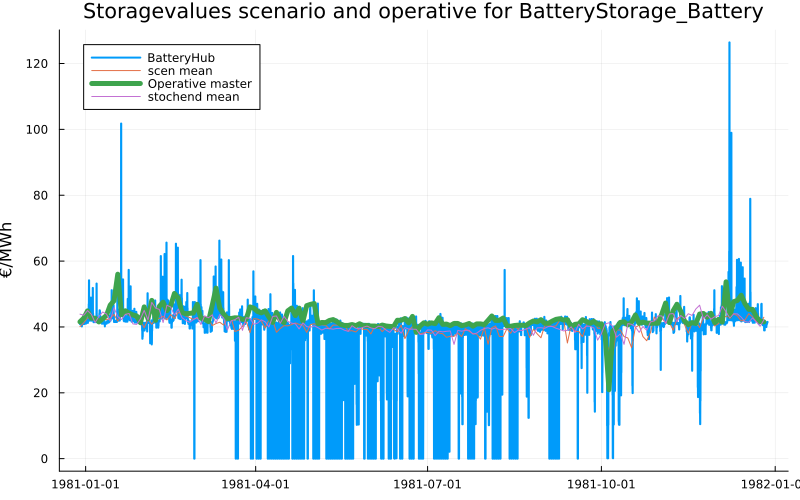

In [11]:
# Plot prices
display(plot(x1, prices, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))

# Plot storages
display(areaplot(x1[1:624], dropdims(sum(batterylevels,dims=2),dims=2)[1:624],labels="Total batteries",size=(800,500),title="Battery levels (zoomed)", ylabel = "GWh", fmt = :html))

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader=false)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader=false)

# Plot list of yearly income and cost for each supply/demand
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
pretty_table(joinedrevdf, show_subheader=false)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader=false)

# Plot storagevalues for each reservoir and scenarios
maxlongtermstorages = 60
maxshorttermstorages = 30
shortindex = x3
medindex = x3[1:Int(skipfactor):end]
numstoch = length(findall(sn -> occursin("min", sn), scenarionames))*2
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numop_acc = numstoch + numop
numstochend = length(findall(sn -> occursin("stochend", sn), scenarionames))
numstochend_acc = numop_acc + numstochend
numevpend = length(findall(sn -> occursin("evpend", sn), scenarionames))
numevpend_acc = numstochend_acc + numevpend
j = 0
k = 0
for (i, storagename) in enumerate(storagenames)
    if shorts[i]
        j += 1
        j > maxshorttermstorages && continue
        storagevalues_ = storagevalues[:,:,:]
        scenweights_stoch_ = scenweights_stoch[:,:]
        index = shortindex
    else
        k += 1
        k > maxlongtermstorages && continue
        storagevalues_ = storagevalues[1:Int(skipfactor):end,:,:]
        scenweights_stoch_ = scenweights_stoch[1:Int(skipfactor):end,:]
        index = medindex
    end
    p = plot(x1, prices[:, 1], labels=powerbalancenames[1], linewidth=2)
    # p = plot(index, storagevalues_[:,1:numstoch,i] / -1000, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numstoch], 1, numstoch), ylabel="€/MWh")
    # plot!(p, index, storagevalues_[:,numstoch+1:numop_acc,i] / -1000, labels=reshape(scenarionames[numstoch+1:numop_acc], 1, numop), linewidth=5)
    # plot!(p, index, storagevalues_[:,numop_acc+1:numstochend_acc,i] / -1000, labels=reshape(scenarionames[numop_acc+1:numstochend_acc], 1, numstochend))
    # if numevpend > 0
    #     plot!(p, index, storagevalues_[:,numstochend_acc+1:numevpend_acc,i] / -1000, labels=reshape(scenarionames[numstochend_acc+1:numevpend_acc], 1, numevpend))
    # end
    stochvalues = (dropdims(sum(storagevalues_[:,1:2:numstoch,i] .* scenweights_stoch_,dims=2),dims=2) .+ dropdims(sum(storagevalues_[:,2:2:numstoch,i] .* scenweights_stoch_,dims=2),dims=2)) / -1 / 2
    plot!(p, index, stochvalues, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels="scen mean", ylabel="€/MWh")
    plot!(p, index, storagevalues_[:,numstoch+1:numop_acc,i] / -1, labels=reshape(scenarionames[numstoch+1:numop_acc], 1, numop), linewidth=5)
    plot!(p, index, dropdims(sum(storagevalues_[:,numop_acc+1:numstochend_acc,i] .* scenweights_stoch_,dims=2),dims=2) / -1, labels="stochend mean")
    if numevpend > 0
        plot!(p, index, dropdims(sum(storagevalues_[:,numstochend_acc+1:numevpend_acc,i] .* scenweights_stoch_,dims=2),dims=2) / -1, labels="evpend mean")
    end
    display(p)
end